In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Importing Dataset

In [4]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697) 
  
# data (as pandas dataframes) 
X = predict_students_dropout_and_academic_success.data.features 
y = predict_students_dropout_and_academic_success.data.targets.squeeze()

In [ ]:
X.info()
X.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 36 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital Status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0,0.000000,0,10.8,1.4,1.74
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,0,6,0,0,0.000000,0,10.8,1.4,1.74
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79


# Splitting the data into training and testing subsets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Preprocessing data using Pipeline

In [6]:
# Make sure y is 1-D on the split pieces (defensive)
y_train = np.ravel(y_train) if hasattr(y_train, "values") else y_train
y_test  = np.ravel(y_test)  if hasattr(y_test, "values")  else y_test

# Select numeric vs categorical columns from the training frame
num_cols = make_column_selector(dtype_include=np.number)(X_train)
cat_cols = make_column_selector(dtype_exclude=np.number)(X_train)

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

# Build preprocessing: impute+scale for numeric, impute+one-hot for categorical
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)


Numeric columns: ['Marital Status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance', 'Previous qualification', 'Previous qualification (grade)', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Admission grade', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation rate', 'GDP']
Catego

# Defining a baseline model with DummyClassifier

In [7]:
baseline_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", DummyClassifier(strategy="most_frequent"))
])
baseline_pipe.fit(X_train, y_train)
y_pred_baseline = baseline_pipe.predict(X_test)


# Building and comparing Logistic Regression and k-NN
### Calculating table of Accuracy, Precision, Recall, and F1-score

In [8]:
def get_metrics(y_true, y_pred, average="macro"):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average=average, zero_division=0),
        "recall": recall_score(y_true, y_pred, average=average, zero_division=0),
        "f1": f1_score(y_true, y_pred, average=average, zero_division=0)
    }

log_reg = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=2000, random_state=42))
])
log_reg.fit(X_train, y_train)
y_pred_logreg = log_reg.predict(X_test)

knn = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", KNeighborsClassifier(n_neighbors=5))
])
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

results = {
    "DummyClassifier": get_metrics(y_test, y_pred_baseline),
    "LogisticRegression": get_metrics(y_test, y_pred_logreg),
    "k-NN": get_metrics(y_test, y_pred_knn)
}
results_df = pd.DataFrame(results).T
print("\nModel Comparison without hyperparamters:")
print(results_df)


Model Comparison without hyperparamters:
                    accuracy  precision    recall        f1
DummyClassifier     0.499435   0.166478  0.333333  0.222055
LogisticRegression  0.768362   0.707005  0.675426  0.682601
k-NN                0.667797   0.580154  0.571895  0.573015


# Tuning hyperparameters

In [13]:
# Set up cv and scoring 
#5-fold stratified CV for classification 
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 
#multiple scores just to inspect,then refit on the most important one 
scoring = {
    "accuracy": "accuracy", 
    "f1_macro": "f1_macro", 
    "precision_macro": "precision_macro", 
    "recall_macro": "recall_macro" 
}

refit_metric = "f1_macro" #the main one, since treats classes equally 

#Tune Logistic Regression (small efficient grid)
pipe_lr = Pipeline(steps = [("prep", preprocess), ("clf", LogisticRegression(max_iter=4000, random_state=42))])

param_grid_lr = {
    "clf__C": [0.01, 0.1, 1, 10, 100], 
    "clf__solver": ["lbfgs", "liblinear"], 
    "clf__penalty": ["l2"]
}

grid_lr = GridSearchCV(estimator=pipe_lr,
                       param_grid=param_grid_lr, 
                       scoring=scoring, 
                       refit=refit_metric, 
                       cv=cv, 
                       n_jobs=-1,
                       verbose=1
                       )

grid_lr.fit(X_train, y_train) 

print("Best params (Logistic Regression): ", grid_lr.best_params_) 
print(f"Best CV {refit_metric} (LogReg): {grid_lr.best_score_:.4f}")

best_lr = grid_lr.best_estimator_ 

#tune k-nearest Neighbors (distance, neighbors, metric)
pipe_knn = Pipeline (steps = [("prep", preprocess), ("clf", KNeighborsClassifier())]) 

param_grid_knn = {
    "clf__n_neighbors": [3, 5, 7, 9, 15], 
    "clf__weights": ["uniform", "distance"], 
    "clf__p": [1, 2] 
}

grid_knn = GridSearchCV(estimator=pipe_knn, 
                        param_grid=param_grid_knn, 
                        scoring=scoring, 
                        refit=refit_metric, 
                        cv=cv, 
                        n_jobs=-1, 
                        verbose=1
                        )

grid_knn.fit(X_train, y_train)

print("Best params (k-NN):", grid_knn.best_params_) 
print(f"Best CV {refit_metric} (k-NN): {grid_knn.best_score_:.4f}")

best_knn = grid_knn.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params (Logistic Regression):  {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best CV f1_macro (LogReg): 0.6758
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params (k-NN): {'clf__n_neighbors': 5, 'clf__p': 1, 'clf__weights': 'uniform'}
Best CV f1_macro (k-NN): 0.6331


# Evaluating and interpreting results with metrics

=== LogReg (tuned) - Test Metrics ===
Accuracy: 0.7718
Averages:
macro     P=0.7130 R=0.6804  F1=0.6882
micro     P=0.7718 R=0.7718  F1=0.7718
weighted  P=0.7544 R=0.7718  F1=0.7571

Per-class classification report:
              precision    recall  f1-score   support

     Dropout       0.79      0.77      0.78       284
    Enrolled       0.54      0.35      0.42       159
    Graduate       0.81      0.93      0.86       442

    accuracy                           0.77       885
   macro avg       0.71      0.68      0.69       885
weighted avg       0.75      0.77      0.76       885



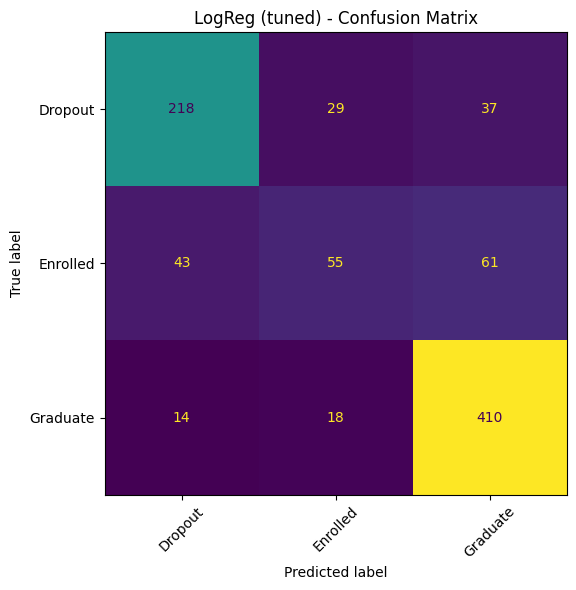

=== k-NN (tuned) - Test Metrics ===
Accuracy: 0.7040
Averages:
macro     P=0.6362 R=0.6152  F1=0.6208
micro     P=0.7040 R=0.7040  F1=0.7040
weighted  P=0.6873 R=0.7040  F1=0.6915

Per-class classification report:
              precision    recall  f1-score   support

     Dropout       0.74      0.68      0.71       284
    Enrolled       0.42      0.30      0.35       159
    Graduate       0.75      0.86      0.80       442

    accuracy                           0.70       885
   macro avg       0.64      0.62      0.62       885
weighted avg       0.69      0.70      0.69       885



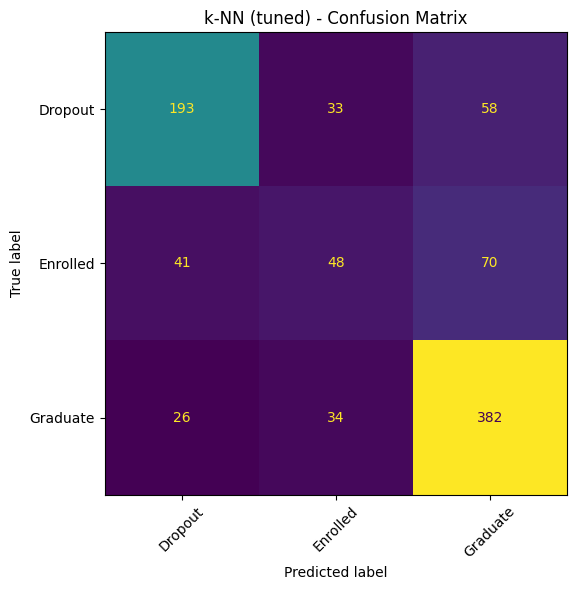

,accuracy,macro_precision,macro_recall,macro_f1,micro_precision,weighted_recall,weighted_f1
LogReg (tuned),0.7718,0.7130,0.6804,0.6882,0.7544,0.7718,0.7571
k-NN (tuned),0.7040,0.6362,0.6152,0.6208,0.6873,0.7040,0.6915


In [14]:
# Confusion matrics
# Accuracy, Precision, Recall, and F1-score With hyperparamters
from matplotlib.pyplot import xticks
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, 
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

def evaluate_model(name, estimator, X_test, y_test): 
    #compute required metrics and show confusion matrix 
    y_pred = estimator.predict(X_test) 

    #accuracy overall 
    acc = accuracy_score(y_test, y_pred) 

    #macro/micro/weighted precision/recall/f1 score 
    avgs = {} 
    for avg in ["macro", "micro", "weighted"]: 
        p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=avg, zero_division=0)
        avgs[avg] = {"precision": p, "recall": r, "f1": f1} 

    # per-class report 
    report = classification_report(y_test, y_pred, zero_division=0)
    print(f"=== {name} - Test Metrics ===") 
    print(f"Accuracy: {acc:.4f}") 
    print("Averages:") 
    for k, v in avgs.items(): 
        print(f"{k:8s}  P={v['precision']:.4f} R={v['recall']:.4f}  F1={v['f1']:.4f}")
    print("\nPer-class classification report:") 
    print(report) 


    # Confusion matrix (class level mistakes) 
    labels = np.unique(np.concatenate([y_test, y_pred])) 
    cm = confusion_matrix(y_test, y_pred, labels=labels) 
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels) 
    fig, ax = plt.subplots(figsize = (7.5, 6))
    disp.plot(ax=ax, xticks_rotation=45, colorbar=False) 
    ax.set_title(f"{name} - Confusion Matrix") 
    plt.tight_layout() 
    plt.show() 

    #return a compact dict for optional comparison tables 
    row = {"accuracy": acc, 
           "macro_precision": avgs["macro"]["precision"], "macro_recall": avgs["macro"]["recall"], "macro_f1": avgs["macro"]["f1"], 
           "micro_precision": avgs["weighted"]["precision"], "weighted_recall": avgs["weighted"]["recall"], "weighted_f1": avgs["weighted"]["f1"]}
    return row

#Evaluate tuned LogReg and tuned k-NN 
rows = {} 
rows["LogReg (tuned)"] = evaluate_model("LogReg (tuned)", grid_lr.best_estimator_, X_test, y_test) 
rows["k-NN (tuned)"] = evaluate_model("k-NN (tuned)", grid_knn.best_estimator_, X_test, y_test) 

#comparison table 
comp_df = pd.DataFrame(rows).T 
display(comp_df.round(4))